### Human In the Loop
Review
For human-in-the-loop, we often want to see our graph outputs as its running.

We laid the foundations for this with streaming.

Goals
Now, let's talk about the motivations for human-in-the-loop:

(1) Approval - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) Debugging - We can rewind the graph to reproduce or avoid issues

(3) Editing - You can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama3-70b-8192")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result


AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.074285714, 'prompt_time': 0.000114279, 'queue_time': 0.053209661, 'total_time': 0.074399993}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run-af6ae14e-aab7-4308-beab-84629a4d9b53-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})

In [3]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm_with_tools=llm.bind_tools(tools)

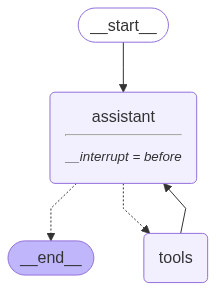

In [23]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
## human in the loop
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}

thread={"configurable":{"thread_id":"1"}}


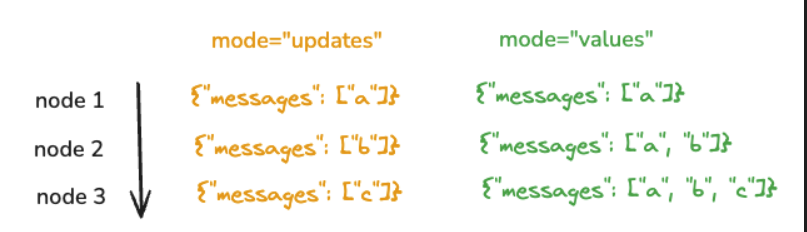

In [18]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()
    

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_d63c)
 Call ID: call_d63c
  Args:
    a: 2
    b: 3


In [19]:
state=graph.get_state(thread)
state.next

('tools',)

In [20]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='ca8b511c-3560-4d98-a61a-0a8ec581bba4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d63c', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 1207, 'total_tokens': 1279, 'completion_time': 0.205714286, 'prompt_time': 0.042871362, 'queue_time': 0.06371347799999999, 'total_time': 0.248585648}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-68fdbf66-875b-4c8e-a015-48c5e516bc8c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_d63c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1207, 'output_tokens': 72, 'total_tokens': 1279})]}, next=('tools',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

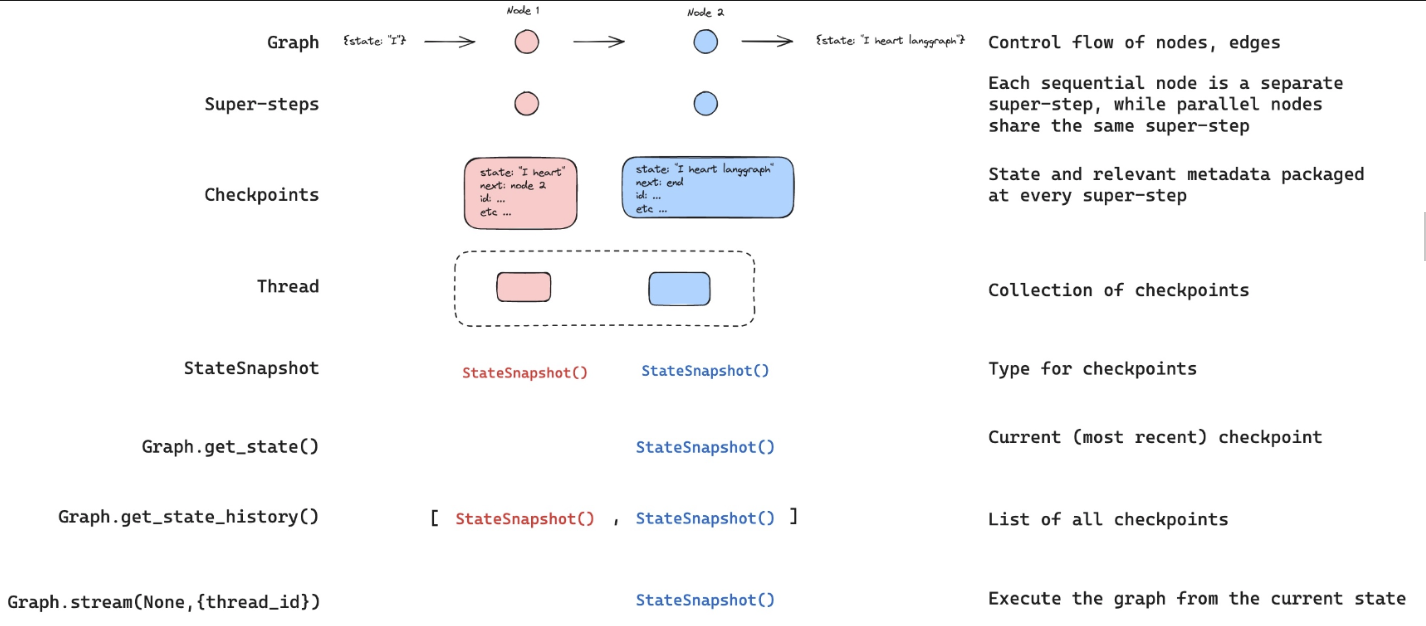

In [21]:
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_d63c)
 Call ID: call_d63c
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result is 6.


In [22]:
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

The result is 6.


### Edit Human Feedback

In [25]:
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}

thread={"configurable":{"thread_id":"1"}}
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [26]:
graph.update_state(thread,{"messages":[HumanMessage(content="No, actually multiply 15 and 5!")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0334e3-543f-68a7-8001-b79f070bb038'}}

In [27]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 15 and 5!


In [33]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

75


### Wait for a USer Input

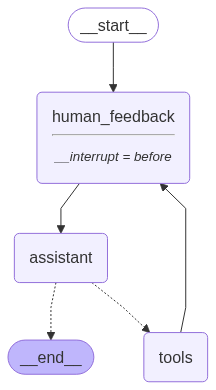

In [34]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


## get user input

user_input=input("Tell me how you want to update the state:")

graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

no please divide 789 divide by 3
================================== Ai Message ==================================
Tool Calls:
  divide (call_jb42)
 Call ID: call_jb42
  Args:
    a: 789
    b: 3
================================= Tool Message =================================
Name: divide

263.0


In [37]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: divide

263.0
================================== Ai Message ==================================

263.0
